In [1]:
# === SEKCJA 1: IMPORTY I KONFIGURACJA ===
import pandas as pd
import numpy as np
import re
from IPython.display import display
import pickle
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
# === SEKCJA 2: WCZYTANIE I PRZYGOTOWANIE DANYCH Z AGREGACJĄ ===
print("--- Przygotowanie danych do modelu (cel: przewidywanie aglomeracji) ---")

try:
    df = pd.read_csv('polska_flats_clean.csv', sep=';')
    print(f"Wczytano {len(df)} czystych wierszy.")
except FileNotFoundError:
    print("BŁĄD: Nie znaleziono pliku 'polska_flats_clean.csv'. Uruchom najpierw skrypt 'pre-processing.ipynb'!")
    raise

# --- 2.1: Czyszczenie i przygotowanie danych ---
numeric_features_raw = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors', 'BuiltYear']
for col in numeric_features_raw:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.reset_index(drop=True, inplace=True)
df['Price_per_sqm'] = df['Price'] / df['Area']
df['Price_per_sqm'].replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_features_cols = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors', 'BuiltYear', 'Price_per_sqm']
imputer = SimpleImputer(strategy='median')
df[numeric_features_cols] = imputer.fit_transform(df[numeric_features_cols])

# === AGREGACJA MIAST ===
miasto_counts = df['Miasto_Name'].value_counts()
major_cities = miasto_counts[miasto_counts >= 20].index
df['target_group'] = np.where(df['Miasto_Name'].isin(major_cities), df['Miasto_Name'], 'Inne')
print(f"\nStworzono {df['target_group'].nunique()} grup docelowych (duże miasta + kategoria 'Inne').")
print("Rozkład grup:")
print(df['target_group'].value_counts())

# --- 2.2: Przygotowanie Danych Wejściowych (X) i Wyjściowych (y) ---
df['description_enriched'] = df['Title'].astype(str) + " " + df['Description'].astype(str) + " " + df['Dzielnica_Name'].fillna('Brak').replace('Brak', '').astype(str)
def clean_text(text): return re.sub(r'[^a-ząęółśżźćń ]', '', str(text).lower())
df['description_clean'] = df['description_enriched'].apply(clean_text)

MAX_WORDS, MAX_LEN = 20000, 250
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
tokenizer.fit_on_texts(df['description_clean'])
X_text = pad_sequences(tokenizer.texts_to_sequences(df['description_clean']), maxlen=MAX_LEN)
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df[numeric_features_cols])

le_group = LabelEncoder()
y = le_group.fit_transform(df['target_group'])
num_classes = len(le_group.classes_)
y_cat = to_categorical(y, num_classes=num_classes)

# --- 2.3: Podział na zbiory ---
X_train_text, X_val_text, X_train_num, X_val_num, y_train, y_val = train_test_split(
    X_text, X_numeric, y_cat,
    test_size=0.2, random_state=42, stratify=y_cat
)
print(f"\nDane podzielone na zbiór treningowy ({len(X_train_text)}) i walidacyjny ({len(X_val_text)}).")

--- Przygotowanie danych do modelu (cel: przewidywanie aglomeracji) ---
Wczytano 1896 czystych wierszy.

Stworzono 9 grup docelowych (duże miasta + kategoria 'Inne').
Rozkład grup:
target_group
Inne         1508
Warszawa      122
Kraków         63
Gdańsk         53
Łódź           38
Poznań         36
Wrocław        35
Bydgoszcz      21
Gdynia         20
Name: count, dtype: int64

Dane podzielone na zbiór treningowy (1516) i walidacyjny (380).


In [3]:
# === SEKCJA 3: BUDOWA, TRENING, OCENA, ZAPIS I PREDYKCJA (WERSJA FINALNA) ===
print("\nBudowa i trening modelu...")
input_text = Input(shape=(MAX_LEN,), name='text_input')
input_numeric = Input(shape=(X_numeric.shape[1],), name='numeric_input')

text_embedding = Embedding(input_dim=MAX_WORDS, output_dim=128)(input_text)
lstm_out = LSTM(128, dropout=0.3)(text_embedding)
concatenated = Concatenate()([lstm_out, input_numeric])
x = Dense(256, activation='relu')(concatenated)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax', name='output_group')(x)

model = Model(inputs=[input_text, input_numeric], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
]

history = model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_val_text, X_val_num], y_val),
    epochs=50, batch_size=64, callbacks=callbacks
)

# --- Ocena modelu ---
print("\n--- Ocena modelu na zbiorze walidacyjnym ---")
loss, accuracy = model.evaluate([X_val_text, X_val_num], y_val, verbose=0)
print(f"\nDokładność na zbiorze walidacyjnym: {accuracy:.4f}")
y_pred_proba = model.predict([X_val_text, X_val_num])
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)
print("\nRaport klasyfikacji na zbiorze walidacyjnym:")
print(classification_report(y_true, y_pred, target_names=le_group.classes_, zero_division=0))

# --- Zapis artefaktów ---
print("\n--- Zapisywanie modelu i artefaktów do produkcji ---")
artifacts_dir = 'model_artifacts_polska_agglomeracje'
os.makedirs(artifacts_dir, exist_ok=True)
model.save(os.path.join(artifacts_dir, 'agglomeration_predictor_model.keras'))
with open(os.path.join(artifacts_dir, 'tokenizer.pkl'), 'wb') as f: pickle.dump(tokenizer, f)
with open(os.path.join(artifacts_dir, 'scaler.pkl'), 'wb') as f: pickle.dump(scaler, f)
with open(os.path.join(artifacts_dir, 'le_group.pkl'), 'wb') as f: pickle.dump(le_group, f)
df.to_csv(os.path.join(artifacts_dir, 'polska_flats_clean_with_groups.csv'), index=False, sep=';')
print(f"Wszystkie artefakty zostały zapisane w folderze: '{artifacts_dir}'")

# --- Predykcja na pełnej bazie ---
print("\n--- Rozpoczynam predykcję na pełnej, czystej bazie danych ---")
full_predictions_proba = model.predict([X_text, X_numeric])
full_predictions_indices = np.argmax(full_predictions_proba, axis=1)
predicted_groups = le_group.inverse_transform(full_predictions_indices)

# === KLUCZOWA POPRAWKA: Inteligentne tworzenie finalnej kolumny Predict_Loc ===
print("Stworzono finalną kolumnę 'Predict_Loc'.")
df['predicted_group'] = predicted_groups

# Logika: Jeśli model przewidział konkretną aglomerację, użyj jej.
# Jeśli przewidział 'Inne', użyj oryginalnej, dokładnej nazwy miasta.
df['Predict_Loc'] = np.where(
    df['predicted_group'] == 'Inne',
    df['Miasto_Name'],
    df['predicted_group']
)

# --- Zapis wyniku do pliku CSV ---
OUTPUT_FILENAME = 'polska_flats_with_predicted_loc.csv'
print(f"\nZapisywanie wyniku do pliku: {OUTPUT_FILENAME}...")
df.to_csv(OUTPUT_FILENAME, index=False, sep=';', encoding='utf-8-sig')
print(f"Zapis zakończony. Plik gotowy do użycia w modelu cen.")

print("\nPróbka finalnych wyników:")
display(df[['Miasto_Name', 'target_group', 'predicted_group', 'Predict_Loc']].head(20))


Budowa i trening modelu...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 250)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 250, 128)          │       2,560,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 128)               │         131,584 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numeric_input (InputLayer)    │ (None, 7)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 135)               │               0 │ lstm[0][0],                │
│                               │                           │                 │ numeric_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │          34,816 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          32,896 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_group (Dense)          │ (None, 9)                 │           1,161 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,760,457 (10.53 MB)

 Trainable params: 2,760,457 (10.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.6615 - loss: 1.7934 - val_accuracy: 0.7947 - val_loss: 1.0413 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.7848 - loss: 1.0165 - val_accuracy: 0.7947 - val_loss: 0.9260 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 0.7939 - loss: 0.7666 - val_accuracy: 0.7947 - val_loss: 0.8301 - learning_rate: 0.0010
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - accuracy: 0.7988 - loss: 0.5469 - val_accuracy: 0.8053 - val_loss: 0.7791 - learning_rate: 0.0010
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.8241 - loss: 0.4664 - val_accuracy: 0.8158 - val_loss: 0.7642 - learning_rate: 0.0010
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - accuracy: 0.8139 - loss: 0.4988 - val_accuracy: 0.8211 - val_loss: 0.7618 - learning_rate: 0.0010
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - accuracy: 0.8467 - loss: 0.4267 -

,Miasto_Name,target_group,predicted_group,Predict_Loc
0,Adamów,Inne,Inne,Adamów
1,Aleksandrów łódzki,Inne,Inne,Aleksandrów łódzki
2,Aleksandrów łódzki,Inne,Inne,Aleksandrów łódzki
3,Aleksandrów łódzki,Inne,Inne,Aleksandrów łódzki
4,Annopol,Inne,Inne,Annopol
5,Babice,Inne,Inne,Babice
6,Babice,Inne,Inne,Babice
7,Baboszewo,Inne,Inne,Baboszewo
8,Baboszewo,Inne,Inne,Baboszewo
9,Bakałarzewo,Inne,Inne,Bakałarzewo


--- Analiza korelacji na danych wejściowych ---

1. Macierz korelacji między cechami numerycznymi:


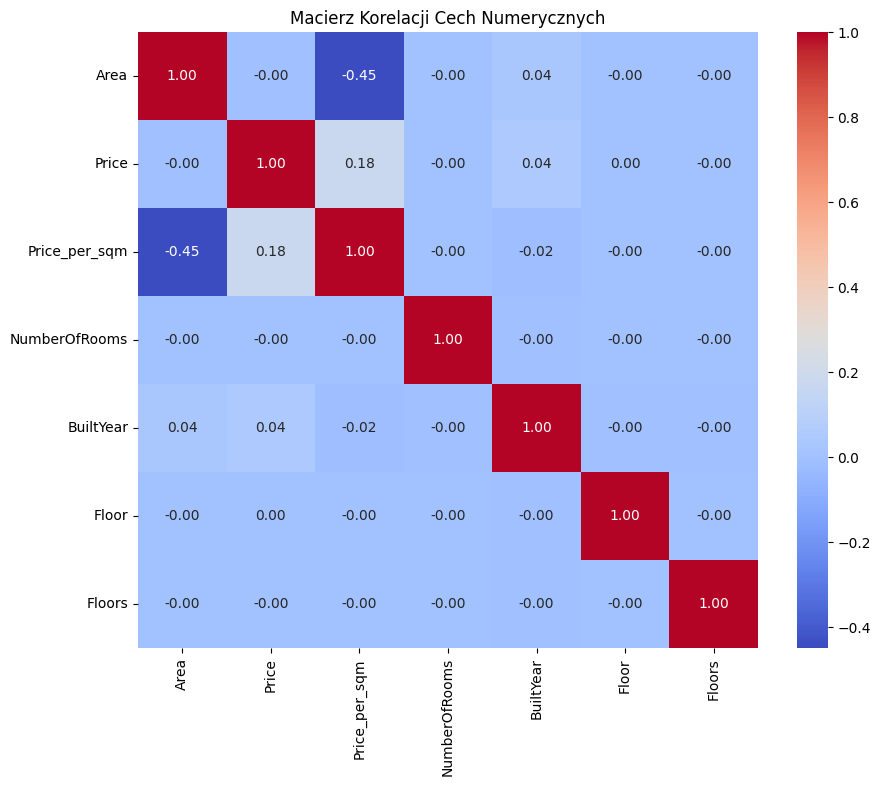


2. Korelacja cech numerycznych z przynależnością do danego miasta:


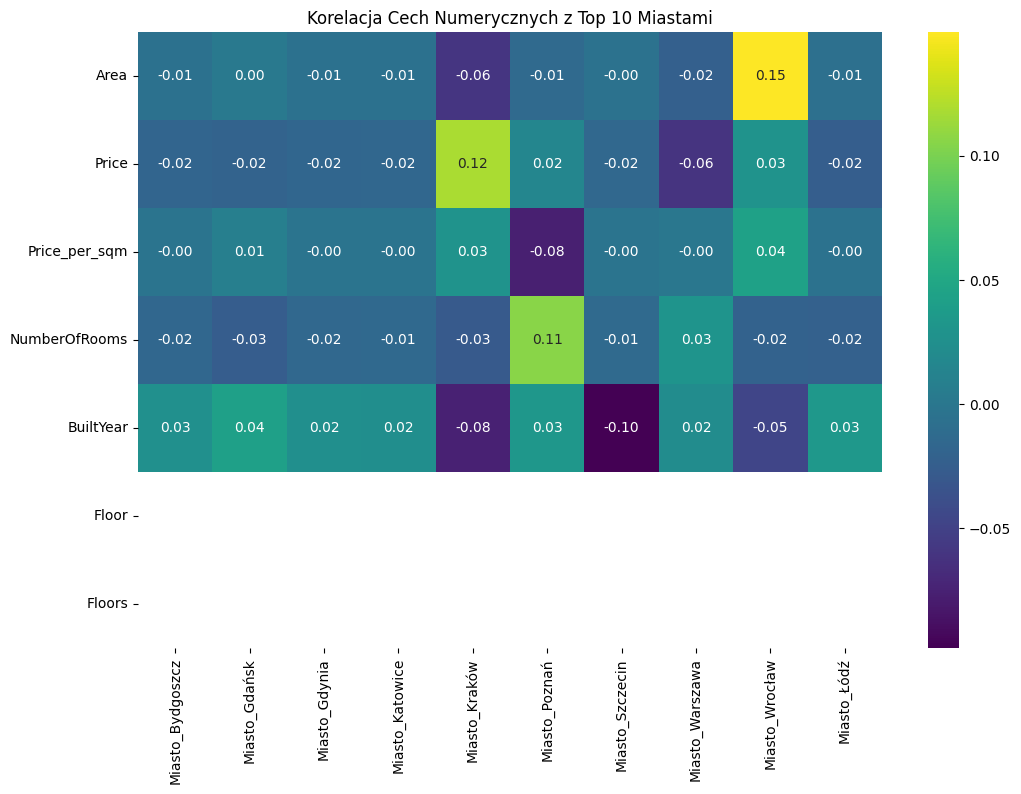

In [5]:
# === SEKCJA 7: ANALIZA DANYCH WEJŚCIOWYCH ZA POMOCĄ MACIERZY KORELACJI ===

import seaborn as sns
import matplotlib.pyplot as plt

print("--- Analiza korelacji na danych wejściowych ---\n")

# Używamy DataFrame 'df' z SEKCJI 2
# --- Metoda 1: Macierz korelacji dla cech numerycznych ---
print("1. Macierz korelacji między cechami numerycznymi:")
correlation_features = ['Area', 'Price', 'Price_per_sqm', 'NumberOfRooms', 'BuiltYear', 'Floor', 'Floors']
corr_matrix = df[correlation_features].corr() # <-- POPRAWKA TUTAJ

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz Korelacji Cech Numerycznych')
plt.show()

# --- Metoda 2: Korelacja cech numerycznych z miastem docelowym ---
print("\n2. Korelacja cech numerycznych z przynależnością do danego miasta:")
df_for_corr = df.copy() # <-- POPRAWKA TUTAJ

top_10_cities = df_for_corr['Miasto_Name'].value_counts().nlargest(10).index
df_top_cities = df_for_corr[df_for_corr['Miasto_Name'].isin(top_10_cities)]
df_encoded = pd.get_dummies(df_top_cities, columns=['Miasto_Name'], prefix='Miasto')
correlation_features_with_cities = correlation_features + [col for col in df_encoded.columns if 'Miasto_' in col]
final_corr_df = df_encoded[correlation_features_with_cities]
city_corr_matrix = final_corr_df.corr()
city_correlations = city_corr_matrix[[col for col in city_corr_matrix.columns if 'Miasto_' in col]].drop([col for col in city_corr_matrix.columns if 'Miasto_' in col])

plt.figure(figsize=(12, 8))
sns.heatmap(city_correlations, annot=True, cmap='viridis', fmt=".2f")
plt.title('Korelacja Cech Numerycznych z Top 10 Miastami')
plt.show()